## Important Libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from matplotlib import cm  # For colormaps
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve
import time

## Grids:

In [2]:
def generate_grid(Nx, Ny, Lx=1.0, Ly=1.0):
    """
    Generates grid points excluding boundaries.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - Lx, Ly: Domain lengths.

    Returns:
    - x, y: 1D arrays of grid points.
    - X, Y: 2D meshgrid arrays.
    - h_x, h_y: Grid spacings.
    """
    h_x = Lx / (Nx + 1)
    h_y = Ly / (Ny + 1)
    x = np.linspace(h_x, Lx - h_x, Nx)
    y = np.linspace(h_y, Ly - h_y, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    return x, y, X, Y, h_x, h_y

## Preparing Right-Hand Side:

In [94]:
def exact_solution(X, Y):
    """Exact solution u(x, y) = sin^2(pi x) sin^2(pi y)."""
    return np.sin(np.pi * X)**2 * np.sin(np.pi * Y)**2

def exact_rhs(X, Y):
    """Right-hand side f(x, y) corresponding to the exact solution."""
    pi = np.pi
    return 2 * pi**2 * (np.cos(2 * pi * X) * (np.sin(pi * Y)**2) + (np.sin(pi * X)**2) * np.cos(2 * pi * Y))

def assemble_rhs_vector(Nx, Ny, X, Y, f_func, g_func, h_x, h_y):
    """
    Assembles the RHS vector b considering boundary conditions.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - X, Y: 2D meshgrid arrays.
    - f_func: Source term function f(x, y).
    - g_func: Boundary condition function g(x, y).
    - h_x, h_y: Grid spacings.

    Returns:
    - b: 1D RHS vector.
    """
    N = Nx * Ny
    b = np.zeros(N)

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i  # Linear index
            b[k] = f_func(X[i, j], Y[i, j]) #! * h_x**2  # Assuming h_x = h_y

            # Boundary conditions
            # Left boundary (x=0)
            if i == 0:
                b[k] += g_func(0, Y[i, j]) / h_x**2
            # Right boundary (x=Lx)
            if i == Nx - 1:
                b[k] += g_func(1.0, Y[i, j]) / h_x**2
            # Bottom boundary (y=0)
            if j == 0:
                b[k] += g_func(X[i, j], 0) / h_y**2
            # Top boundary (y=Ly)
            if j == Ny - 1:
                b[k] += g_func(X[i, j], 1.0) / h_y**2

    return b


In [95]:
def assemble_rhs_vector_fourth_order(Nx, Ny, X, Y, f_func, g_func, h_x, h_y):
    """
    Assembles the RHS vector b for the fourth-order finite difference scheme, considering boundary conditions.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - X, Y: 2D meshgrid arrays.
    - f_func: Source term function f(x, y).
    - g_func: Boundary condition function g(x, y).
    - h_x, h_y: Grid spacings.

    Returns:
    - b: 1D RHS vector.
    """
    N = Nx * Ny
    b = np.zeros(N)

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i  # Linear index
            b[k] = f_func(X[i, j], Y[i, j]) #! * (h_x**2)  # Adjusted for fourth-order scheme

            # Boundary conditions (Dirichlet: u = 0 on boundaries)
            # Since we are using fourth-order, we need to account for two layers of boundary points
            # However, with u = 0, contributions simplify
            # Left boundary (x=0)
            if i == 0:
                b[k] += (16.0 / (12.0 * h_x**2)) * g_func(0, Y[i, j])
            elif i == 1:
                b[k] += (-1.0 / (12.0 * h_x**2)) * g_func(0, Y[i, j])
            # Right boundary (x=Lx)
            if i == Nx - 1:
                b[k] += (16.0 / (12.0 * h_x**2)) * g_func(1.0, Y[i, j])
            elif i == Nx - 2:
                b[k] += (-1.0 / (12.0 * h_x**2)) * g_func(1.0, Y[i, j])
            # Bottom boundary (y=0)
            if j == 0:
                b[k] += (16.0 / (12.0 * h_y**2)) * g_func(X[i, j], 0)
            elif j == 1:
                b[k] += (-1.0 / (12.0 * h_y**2)) * g_func(X[i, j], 0)
            # Top boundary (y=Ly)
            if j == Ny - 1:
                b[k] += (16.0 / (12.0 * h_y**2)) * g_func(X[i, j], 1.0)
            elif j == Ny - 2:
                b[k] += (-1.0 / (12.0 * h_y**2)) * g_func(X[i, j], 1.0)

    return b



## Matrix A Preparation:

In [5]:
def assemble_dense_matrix(Nx, Ny, h_x, h_y):
    """
    Assembles the dense matrix A for the Poisson equation.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - h_x, h_y: Grid spacings.

    Returns:
    - A_dense: Dense numpy array representing the Laplacian.
    """
    N = Nx * Ny
    A_dense = np.zeros((N, N))

    for j in range(Ny):
        for i in range(Nx):
            k = j * Nx + i
            A_dense[k, k] = 4.0 / h_x**2  # Diagonal

            # Left neighbor
            if i > 0:
                A_dense[k, k - 1] = -1.0 / h_x**2
            # Right neighbor
            if i < Nx - 1:
                A_dense[k, k + 1] = -1.0 / h_x**2
            # Bottom neighbor
            if j > 0:
                A_dense[k, k - Nx] = -1.0 / h_y**2
            # Top neighbor
            if j < Ny - 1:
                A_dense[k, k + Nx] = -1.0 / h_y**2

    return - A_dense    #! *-1 due to - laplation

def assemble_sparse_matrix(Nx, Ny, h_x, h_y):
    """
    Assembles the sparse matrix A for the Poisson equation using a second-order finite difference scheme.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - h_x, h_y: Grid spacings.

    Returns:
    - A_sparse: Sparse matrix (CSR format) representing the Laplacian.
    """
    # 1D Second-Order Laplacian T
    main_diag = 2.0 / h_x**2 * np.ones(Nx)
    off_diag = -1.0 / h_x**2 * np.ones(Nx - 1)
    T = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csr')

    # Identity matrix
    I = eye(Nx, format='csr')

    # 2D Laplacian using Kronecker product
    A_sparse = kron(I, T) + kron(T, I)

    return -A_sparse    #!

def assemble_sparse_matrix_fourth_order(Nx, Ny, h):
    """
    Assembles the sparse matrix A for the Poisson equation using a fourth-order finite difference scheme.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - h: Grid spacing (assuming h_x = h_y = h).

    Returns:
    - A_sparse: Sparse matrix (CSR format) representing the Laplacian.
    """
    # 1D Fourth-Order Laplacian T
    main_diag = -30.0 / (12.0 * h**2) * np.ones(Nx)
    first_off_diag = 16.0 / (12.0 * h**2) * np.ones(Nx - 1)
    second_off_diag = -1.0 / (12.0 * h**2) * np.ones(Nx - 2)

    diagonals = [second_off_diag, first_off_diag, main_diag, first_off_diag, second_off_diag]
    offsets = [-2, -1, 0, 1, 2]
    T = diags(diagonals, offsets, shape=(Nx, Nx), format='csr')

    # Identity matrix
    I = eye(Nx, format='csr')

    # 2D Laplacian using Kronecker product
    A_sparse = kron(I, T) + kron(T, I)

    return A_sparse       #!


## Methods:

In [6]:
def jacobi_method(A_sparse, b, tol=1e-6, max_iterations=1000):
    """
    Implements the Jacobi iterative method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - u: Solution vector.
    - iterations: Number of iterations performed.
    - residuals: List of residual norms at each iteration.
    """
    D = A_sparse.diagonal()
    R = A_sparse - diags(D, offsets=0)
    D_inv = 1.0 / D
    u = np.zeros_like(b)
    residuals = []

    for it in range(max_iterations):
        u_new = D_inv * (b - R.dot(u))
        residual = np.linalg.norm(b - A_sparse.dot(u_new), ord=np.inf)
        residuals.append(residual)
        if residual < tol:
            return u_new, it+1, residuals
        u = u_new

    print("Jacobi method did not converge within the maximum number of iterations.")
    return u, it+1, residuals

In [7]:
def gauss_seidel_method(A_sparse, b, tol=1e-6, max_iterations=1000):
    """
    Implements the Gauss-Seidel iterative method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - u: Solution vector.
    - iterations: Number of iterations performed.
    - residuals: List of residual norms at each iteration.
    """
    u = np.zeros_like(b)
    residuals = []
    N = len(b)

    A_csr = A_sparse.tocsr()

    for it in range(max_iterations):
        for i in range(N):
            row_start = A_csr.indptr[i]
            row_end = A_csr.indptr[i+1]
            Ai = A_csr.indices[row_start:row_end]
            Av = A_csr.data[row_start:row_end]

            sum_ = 0.0
            diag = 0.0
            for idx, col in enumerate(Ai):
                if col == i:
                    diag = Av[idx]
                else:
                    sum_ += Av[idx] * u[col]
            u[i] = (b[i] - sum_) / diag

        residual = np.linalg.norm(b - A_sparse.dot(u), ord=np.inf)
        residuals.append(residual)
        if residual < tol:
            return u, it+1, residuals

    print("Gauss-Seidel method did not converge within the maximum number of iterations.")
    return u, it+1, residuals


In [8]:
def sor_method(A_sparse, b, omega, tol=1e-6, max_iterations=1000):
    """
    Implements the Successive Over-Relaxation (SOR) method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - omega: Relaxation parameter.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - u: Solution vector.
    - iterations: Number of iterations performed.
    - residuals: List of residual norms at each iteration.
    """
    u = np.zeros_like(b)
    residuals = []
    N = len(b)
    A_csr = A_sparse.tocsr()

    for it in range(max_iterations):
        for i in range(N):
            row_start = A_csr.indptr[i]
            row_end = A_csr.indptr[i+1]
            Ai = A_csr.indices[row_start:row_end]
            Av = A_csr.data[row_start:row_end]

            sum_ = 0.0
            diag = 0.0
            for idx, col in enumerate(Ai):
                if col == i:
                    diag = Av[idx]
                else:
                    sum_ += Av[idx] * u[col]
            u_new = (1 - omega) * u[i] + (omega / diag) * (b[i] - sum_)
            u[i] = u_new

        residual = np.linalg.norm(b - A_sparse.dot(u), ord=np.inf)
        residuals.append(residual)
        if residual < tol:
            return u, it+1, residuals

    print("SOR method did not converge within the maximum number of iterations.")
    return u, it+1, residuals

def find_optimal_omega(A_sparse, b, omegas, tol=1e-6, max_iterations=1000):
    """
    Finds the optimal relaxation parameter omega for the SOR method.

    Parameters:
    - A_sparse: Sparse matrix A in CSR format.
    - b: RHS vector.
    - omegas: List or array of omega values to test.
    - tol: Tolerance for convergence.
    - max_iterations: Maximum number of iterations.

    Returns:
    - optimal_omega: Omega with the least number of iterations.
    - omega_iterations: Dictionary mapping omega to iterations.
    """
    omega_iterations = {}
    for omega in omegas:
        _, iter_count, _ = sor_method(A_sparse, b, omega, tol, max_iterations)
        omega_iterations[omega] = iter_count
        print(f"Omega: {omega:.2f}, Iterations: {iter_count}")

    # Find omega with minimum iterations
    optimal_omega = min(omega_iterations, key=omega_iterations.get)
    return optimal_omega, omega_iterations


## Solvers:

In [74]:
def solve_poisson_direct(A, b, method='dense'):
    """
    Solves the Poisson equation using a direct solver.

    Parameters:
    - A: Matrix (dense or sparse).
    - b: RHS vector.
    - method: 'dense' or 'sparse'.

    Returns:
    - u: Solution vector.
    - solve_time: Time taken to solve.
    """
    start_time = time.time()
    if method == 'dense':
        u = np.linalg.solve(A, b)
    elif method == 'sparse':
        u = spsolve(A, b)
    else:
        raise ValueError("Method must be 'dense' or 'sparse'")
    end_time = time.time()
    solve_time = end_time - start_time
    return u, solve_time

def solve_poisson_fourth_order(Nx, Ny, Lx=1.0, Ly=1.0, g_func=lambda x, y: 0.0): #, tol=1e-6, max_iterations=1000):
    """
    Solves the Poisson equation using a fourth-order finite difference scheme.

    Parameters:
    - Nx, Ny: Number of interior points along x and y.
    - Lx, Ly: Domain lengths.
    - g_func: Boundary condition function.

    Returns:
    - U_numeric: Numerical solution as a 2D array.
    - solve_time: Time taken to solve.
    - rel_error: Relative error compared to exact solution.
    """
    # Generate grid
    x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, Lx, Ly)

    # Compute exact solution and RHS
    U_exact = exact_solution(X, Y)
    f_exact = exact_rhs(X, Y)

    # Assemble RHS vector
    b = assemble_rhs_vector_fourth_order(Nx, Ny, X, Y, exact_rhs, g_func, h_x, h_y)

    # Assemble Fourth-Order Sparse Matrix
    A_sparse = assemble_sparse_matrix_fourth_order(Nx, Ny, h_x)

    # Solve using Sparse Solver
    print("\nSolving using Fourth-Order Sparse Matrix Representation...")
    u_sparse, solve_time = solve_poisson_direct(A_sparse, b, method='sparse')    #! changed
    U_sparse = u_sparse.reshape((Nx, Ny))
    # rel_error = compute_relative_error(u_sparse, U_exact.flatten())
    # rel_error_2 = np.linalg.norm(np.abs((u_sparse - U_exact.flatten()) / (U_exact.flatten() + 1e-12)))
    
    print(f"Fourth-Order Sparse Solver: Time = {solve_time:.4f}s") #, Relative Error = {rel_error:.5e}")

    return U_sparse, solve_time#, rel_error


## Calculations:

In [104]:
def compute_relative_error(U_num, U_exact):
    """
    Computes the relative error in the maximum norm.

    Parameters:
    - U_num: Numerical solution (1D array).
    - U_exact: Exact solution (1D array).

    Returns:
    - rel_error: Relative error.
    """
    # print(f"U_num = {U_num}")
    # print(f"u_exact= {U_exact}")
    # print(f"eror = {np.abs(U_num - U_exact)}")
    error = np.abs(U_num - U_exact)
    rel_error = np.max(error) / np.max(np.abs(U_exact))

    rel_error_3 = np.linalg.norm(error) / np.max(np.abs(U_exact))

    #! 
    rel_error_2 = np.linalg.norm(np.abs((U_num - U_exact)/ (U_exact + 1e-20)))
    return rel_error


def plot_3d_surface(X, Y, Z, title='3D Surface Plot'):
    """
    Plots a 3D surface.

    Parameters:
    - X, Y: 2D meshgrid arrays.
    - Z: 2D array representing the function values at grid points.
    - title: Title of the plot.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False)

    # Add a color bar
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # Set labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('u(x, y)')
    ax.set_title(title)

    plt.show()

## comparisons:

In [20]:
def perform_direct_methods_comparison():
    """
    Compares dense and sparse direct solvers in terms of computational time and accuracy.
    """
    # Grid parameters
    Nx, Ny = 40, 40  # Adjust as needed
    Lx, Ly = 1.0, 1.0

    # Generate grid
    x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, Lx, Ly)

    # Compute exact solution and RHS
    U_exact = exact_solution(X, Y)
    f_exact = exact_rhs(X, Y)

    # Boundary condition
    g_homogeneous = lambda x, y: 0.0

    # Assemble RHS vector
    b = assemble_rhs_vector(Nx, Ny, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

    # Assemble Dense Matrix
    A_dense = assemble_dense_matrix(Nx, Ny, h_x, h_y)

    # Solve using Dense Solver
    print("Solving using Dense Matrix Representation...")
    u_dense, time_dense = solve_poisson_direct(A_dense, b, method='dense')
    U_dense = u_dense.reshape((Nx, Ny))
    rel_error_dense = compute_relative_error(u_dense, U_exact.flatten())
    print(f"Dense Solver: Time = {time_dense:.4f}s, Relative Error = {rel_error_dense:.5e}")

    # Assemble Sparse Matrix using Kronecker Product
    A_sparse = assemble_sparse_matrix(Nx, Ny, h_x, h_y)

    # Solve using Sparse Solver
    print("\nSolving using Sparse Matrix Representation...")
    u_sparse, time_sparse = solve_poisson_direct(A_sparse, b, method='sparse')
    U_sparse = u_sparse.reshape((Nx, Ny))
    rel_error_sparse = compute_relative_error(u_sparse, U_exact.flatten())
    print(f"Sparse Solver: Time = {time_sparse:.4f}s, Relative Error = {rel_error_sparse:.5e}")

    # Comparison Results
    print("\nComparison:")
    print(f"Dense Solver Time: {time_dense:.4f}s")
    print(f"Sparse Solver Time: {time_sparse:.4f}s")
    print(f"Relative Error (Dense): {rel_error_dense:.5e}")
    print(f"Relative Error (Sparse): {rel_error_sparse:.5e}")

    # Plotting Numerical vs Exact Solution (Optional)
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.contourf(X, Y, U_dense, 50, cmap='viridis')
    plt.colorbar()
    plt.title('Numerical Solution (Dense)')

    plt.subplot(1, 2, 2)
    plt.contourf(X, Y, U_sparse, 50, cmap='viridis')
    plt.colorbar()
    plt.title('Numerical Solution (Sparse)')

    plt.show()
    
def compare_iterative_methods_3d():
    """
    Compares Jacobi, Gauss-Seidel, and SOR methods in terms of residual convergence and visualizes their solutions in 3D.
    """
    # Grid parameters
    Nx, Ny = 40, 40  # You can adjust this for finer/coarser grids
    Lx, Ly = 1.0, 1.0

    # Generate grid
    x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, Lx, Ly)

    # Exact solution and RHS
    U_exact = exact_solution(X, Y)
    f_exact = exact_rhs(X, Y)

    # Boundary condition
    g_homogeneous = lambda x, y: 0.0

    # Assemble RHS vector
    b = assemble_rhs_vector(Nx, Ny, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

    # Assemble Sparse Matrix
    A_sparse = assemble_sparse_matrix(Nx, Ny, h_x, h_y)

    # Jacobi Method
    print("Running Jacobi Method...")
    u_jacobi, iter_jacobi, res_jacobi = jacobi_method(A_sparse, b, tol=1e-6, max_iterations=1000)
    error_jacobi = compute_relative_error(u_jacobi, exact_solution(X, Y).flatten())
    print(f"Jacobi Method: Iterations = {iter_jacobi}, Relative Error = {error_jacobi:.5e}")

    # Gauss-Seidel Method
    print("\nRunning Gauss-Seidel Method...")
    u_gs, iter_gs, res_gs = gauss_seidel_method(A_sparse, b, tol=1e-6, max_iterations=1000)
    error_gs = compute_relative_error(u_gs, exact_solution(X, Y).flatten())
    print(f"Gauss-Seidel Method: Iterations = {iter_gs}, Relative Error = {error_gs:.5e}")

    # SOR Method
    omegas = np.arange(1.0, 2.0, 0.05)
    print("\nFinding optimal omega for SOR method...")
    optimal_omega, omega_iterations = find_optimal_omega(A_sparse, b, omegas, tol=1e-6, max_iterations=1000)
    print(f"\nOptimal Omega: {optimal_omega:.2f}, with {omega_iterations[optimal_omega]} iterations.")

    print(f"\nRunning SOR with optimal omega = {optimal_omega:.2f}")
    u_sor, iter_sor_actual, res_sor = sor_method(A_sparse, b, optimal_omega, tol=1e-6, max_iterations=1000)
    rel_error_sor = compute_relative_error(u_sor, exact_solution(X, Y).flatten())
    print(f"SOR Method: Iterations = {iter_sor_actual}, Relative Error = {rel_error_sor:.5e}")

    # Reshape solutions for plotting
    U_jacobi = u_jacobi.reshape((Nx, Ny))
    U_gs = u_gs.reshape((Nx, Ny))
    U_sor = u_sor.reshape((Nx, Ny))

    # Plot Exact Solution
    plot_3d_surface(X, Y, exact_solution(X, Y), title='Exact Solution')

    # Plot Jacobi Solution
    plot_3d_surface(X, Y, U_jacobi, title=f'Jacobi Solution (Iterations: {iter_jacobi})')

    # Plot Gauss-Seidel Solution
    plot_3d_surface(X, Y, U_gs, title=f'Gauss-Seidel Solution (Iterations: {iter_gs})')

    # Plot SOR Solution
    plot_3d_surface(X, Y, U_sor, title=f'SOR Solution (Iterations: {iter_sor_actual}, Omega: {optimal_omega:.2f})')

    # Optionally, create a combined plot to overlay all solutions
    fig = plt.figure(figsize=(16, 12))

    # Exact Solution
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, exact_solution(X, Y), cmap=cm.viridis, linewidth=0, antialiased=False)
    ax1.set_title('Exact Solution')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')
    ax1.set_zlabel('u(x, y)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # Jacobi Solution
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, U_jacobi, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax2.set_title(f'Jacobi Solution\nIterations: {iter_jacobi}')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    ax2.set_zlabel('u(x, y)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    # Gauss-Seidel Solution
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    surf3 = ax3.plot_surface(X, Y, U_gs, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax3.set_title(f'Gauss-Seidel Solution\nIterations: {iter_gs}')
    ax3.set_xlabel('X-axis')
    ax3.set_ylabel('Y-axis')
    ax3.set_zlabel('u(x, y)')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)

    # SOR Solution
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    surf4 = ax4.plot_surface(X, Y, U_sor, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax4.set_title(f'SOR Solution\nIterations: {iter_sor_actual}, Omega: {optimal_omega:.2f}')
    ax4.set_xlabel('X-axis')
    ax4.set_ylabel('Y-axis')
    ax4.set_zlabel('u(x, y)')
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.show()


## Results:

In [25]:
def plot_iterations_vs_omega(omega_iterations):
    """
    Plots the number of iterations against omega values.

    Parameters:
    - omega_iterations: Dictionary mapping omega to iterations.
    """
    omegas = list(omega_iterations.keys())
    iterations = list(omega_iterations.values())

    plt.figure(figsize=(8,6))
    plt.plot(omegas, iterations, 'o-', color='purple')
    plt.xlabel('Relaxation Parameter (omega)')
    plt.ylabel('Number of Iterations')
    plt.title('SOR: Iterations vs. Relaxation Parameter')
    plt.grid(True)
    plt.show()

def perform_convergence_study_direct_methods():
    """
    Performs a convergence study comparing dense and sparse direct solvers.
    """
    grid_sizes = [10, 20, 40, 80]  # Number of interior points along each axis
    errors_dense = []
    errors_sparse = []
    hs = []
    times_dense = []
    times_sparse = []

    for N in grid_sizes:
        print(f"\nGrid Size: {N}x{N}")
        # Generate grid
        x, y, X, Y, h_x, h_y = generate_grid(N, N, 1.0, 1.0)

        # Exact solution and RHS
        U_exact = exact_solution(X, Y)
        f_exact = exact_rhs(X, Y)

        # Boundary condition
        g_homogeneous = lambda x, y: 0.0

        # Assemble RHS vector
        b = assemble_rhs_vector(N, N, X, Y, exact_rhs, g_homogeneous, h_x, h_y)

        # Dense Matrix and Solver
        A_dense = assemble_dense_matrix(N, N, h_x, h_y)
        u_dense, time_dense = solve_poisson_direct(A_dense, b, method='dense')
        rel_error_dense = compute_relative_error(u_dense, U_exact.flatten())
        errors_dense.append(rel_error_dense)
        times_dense.append(time_dense)
        print(f"Dense Solver: Time = {time_dense:.4f}s, Relative Error = {rel_error_dense:.5e}")

        # Sparse Matrix and Solver
        A_sparse = assemble_sparse_matrix(N, N, h_x, h_y)
        u_sparse, time_sparse = solve_poisson_direct(A_sparse, b, method='sparse')
        rel_error_sparse = compute_relative_error(u_sparse, U_exact.flatten())
        errors_sparse.append(rel_error_sparse)
        times_sparse.append(time_sparse)
        print(f"Sparse Solver: Time = {time_sparse:.4f}s, Relative Error = {rel_error_sparse:.5e}")

        # Record step size
        h = 1.0 / (N + 1)
        hs.append(h)

    # Convergence Plot
    plt.figure(figsize=(8,6))
    plt.loglog(hs, errors_dense, 'o-', label='Dense Solver Error')
    plt.loglog(hs, errors_sparse, 's-', label='Sparse Solver Error')
    plt.loglog(hs, [errors_dense[0]*(hs[0]/h)**2 for h in hs], 'b--', label='O(h²) Reference')
    plt.xlabel('Step size (h)')
    plt.ylabel('Maximum Relative Error')
    plt.title('Convergence Study: Dense vs Sparse Direct Solvers')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Solve Time Plot
    plt.figure(figsize=(8,6))
    plt.loglog(hs, times_dense, 'o-', label='Dense Solver Time')
    plt.loglog(hs, times_sparse, 's-', label='Sparse Solver Time')
    plt.xlabel('Step size (h)')
    plt.ylabel('Solve Time (s)')
    plt.title('Solve Time vs. Step Size: Dense vs Sparse')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Print Convergence Rates
    print("\nEstimated Convergence Rates for Dense Solver:")
    for i in range(1, len(errors_dense)):
        rate = np.log(errors_dense[i]/errors_dense[i-1]) / np.log(hs[i]/hs[i-1])
        print(f"From grid size {grid_sizes[i-1]}x{grid_sizes[i-1]} to {grid_sizes[i]}x{grid_sizes[i]}: Rate ≈ {rate:.2f}")

    print("\nEstimated Convergence Rates for Sparse Solver:")
    for i in range(1, len(errors_sparse)):
        rate = np.log(errors_sparse[i]/errors_sparse[i-1]) / np.log(hs[i]/hs[i-1])
        print(f"From grid size {grid_sizes[i-1]}x{grid_sizes[i-1]} to {grid_sizes[i]}x{grid_sizes[i]}: Rate ≈ {rate:.2f}")


=== Direct Methods Comparison (Second-Order) ===
Solving using Dense Matrix Representation...
Dense Solver: Time = 0.1337s, Relative Error = 1.95939e-03

Solving using Sparse Matrix Representation...
Sparse Solver: Time = 0.0084s, Relative Error = 1.95939e-03

Comparison:
Dense Solver Time: 0.1337s
Sparse Solver Time: 0.0084s
Relative Error (Dense): 1.95939e-03
Relative Error (Sparse): 1.95939e-03


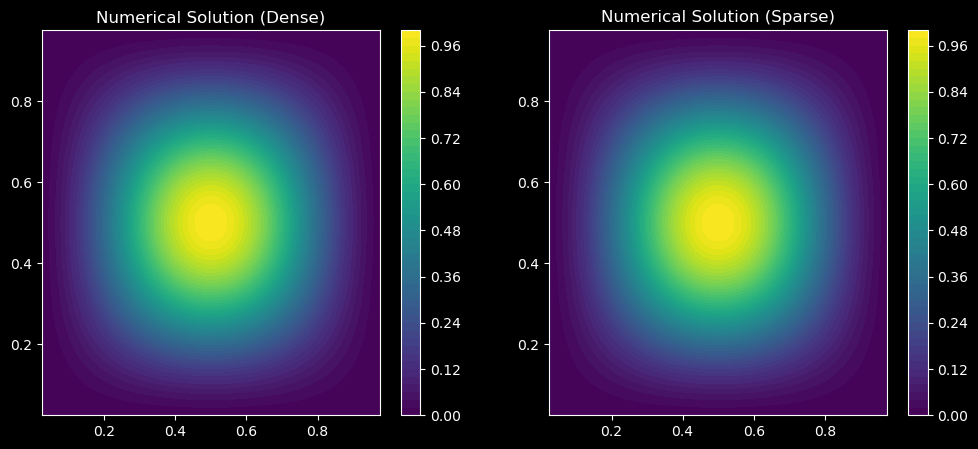

In [107]:
print("=== Direct Methods Comparison (Second-Order) ===")
perform_direct_methods_comparison()


=== Convergence Study for Direct Methods (Second-Order) ===

Grid Size: 10x10
Dense Solver: Time = 0.0700s, Relative Error = 2.76383e-02
Sparse Solver: Time = 0.0005s, Relative Error = 2.76383e-02

Grid Size: 20x20
Dense Solver: Time = 0.0969s, Relative Error = 7.49353e-03
Sparse Solver: Time = 0.0016s, Relative Error = 7.49353e-03

Grid Size: 40x40
Dense Solver: Time = 0.1079s, Relative Error = 1.95939e-03
Sparse Solver: Time = 0.0076s, Relative Error = 1.95939e-03

Grid Size: 80x80
Dense Solver: Time = 4.0476s, Relative Error = 5.01579e-04
Sparse Solver: Time = 0.0314s, Relative Error = 5.01579e-04


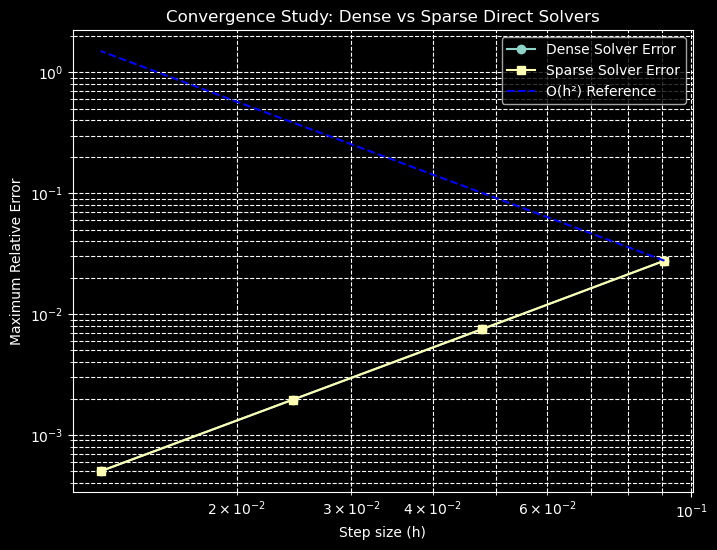

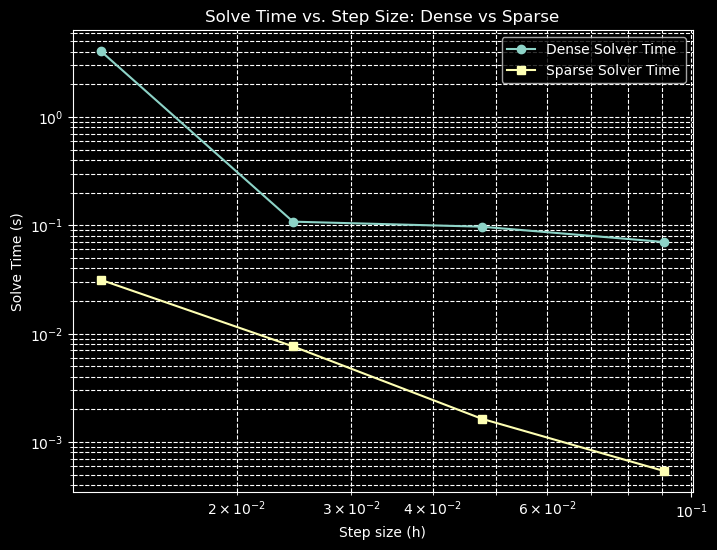


Estimated Convergence Rates for Dense Solver:
From grid size 10x10 to 20x20: Rate ≈ 2.02
From grid size 20x20 to 40x40: Rate ≈ 2.00
From grid size 40x40 to 80x80: Rate ≈ 2.00

Estimated Convergence Rates for Sparse Solver:
From grid size 10x10 to 20x20: Rate ≈ 2.02
From grid size 20x20 to 40x40: Rate ≈ 2.00
From grid size 40x40 to 80x80: Rate ≈ 2.00


In [108]:
print("\n=== Convergence Study for Direct Methods (Second-Order) ===")
perform_convergence_study_direct_methods()


=== Comparing Iterative Methods with 3D Visualization ===
Running Jacobi Method...
Jacobi method did not converge within the maximum number of iterations.
Jacobi Method: Iterations = 1000, Relative Error = 3.63185e-02

Running Gauss-Seidel Method...
Gauss-Seidel method did not converge within the maximum number of iterations.
Gauss-Seidel Method: Iterations = 1000, Relative Error = 5.89119e-04

Finding optimal omega for SOR method...
SOR method did not converge within the maximum number of iterations.
Omega: 1.00, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.05, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.10, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.15, Iterations: 1000
SOR method did not converge within the maximum number of iterations.
Omega: 1.20, Iterations: 1000
SOR method did not converge within the maximum number of iteration

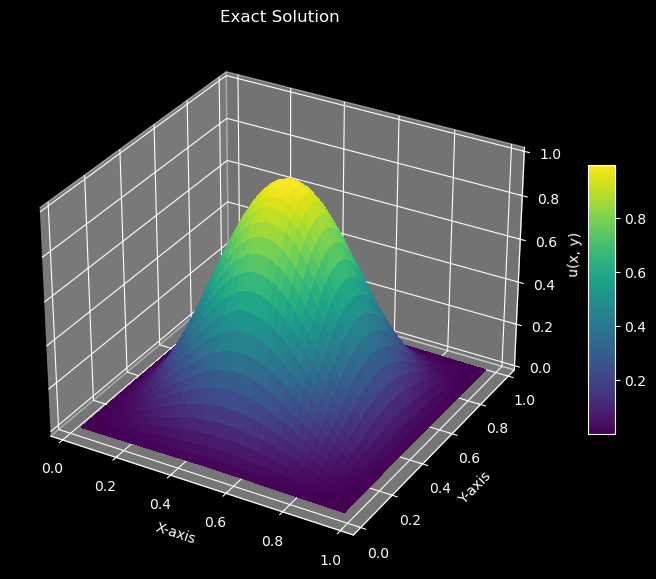

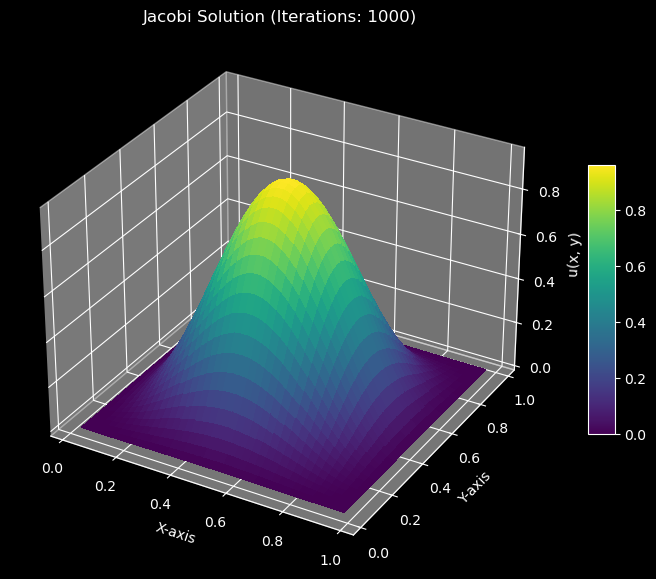

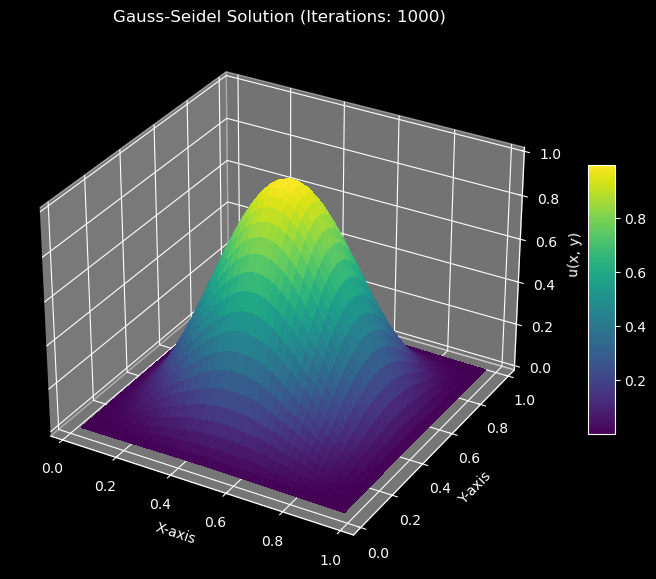

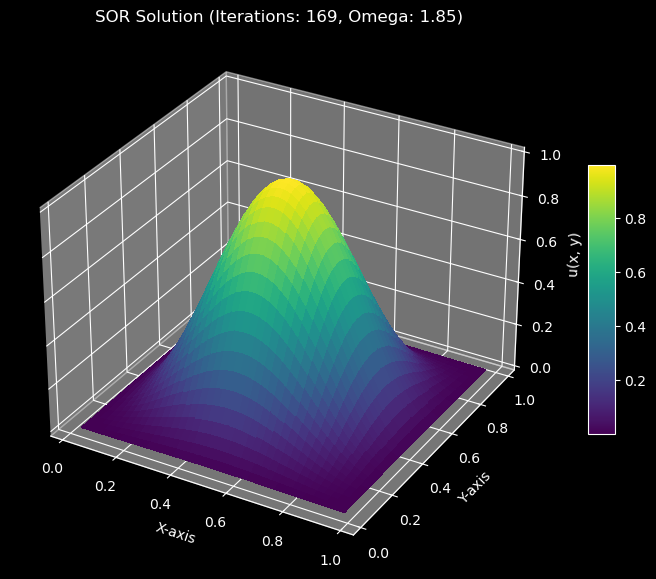

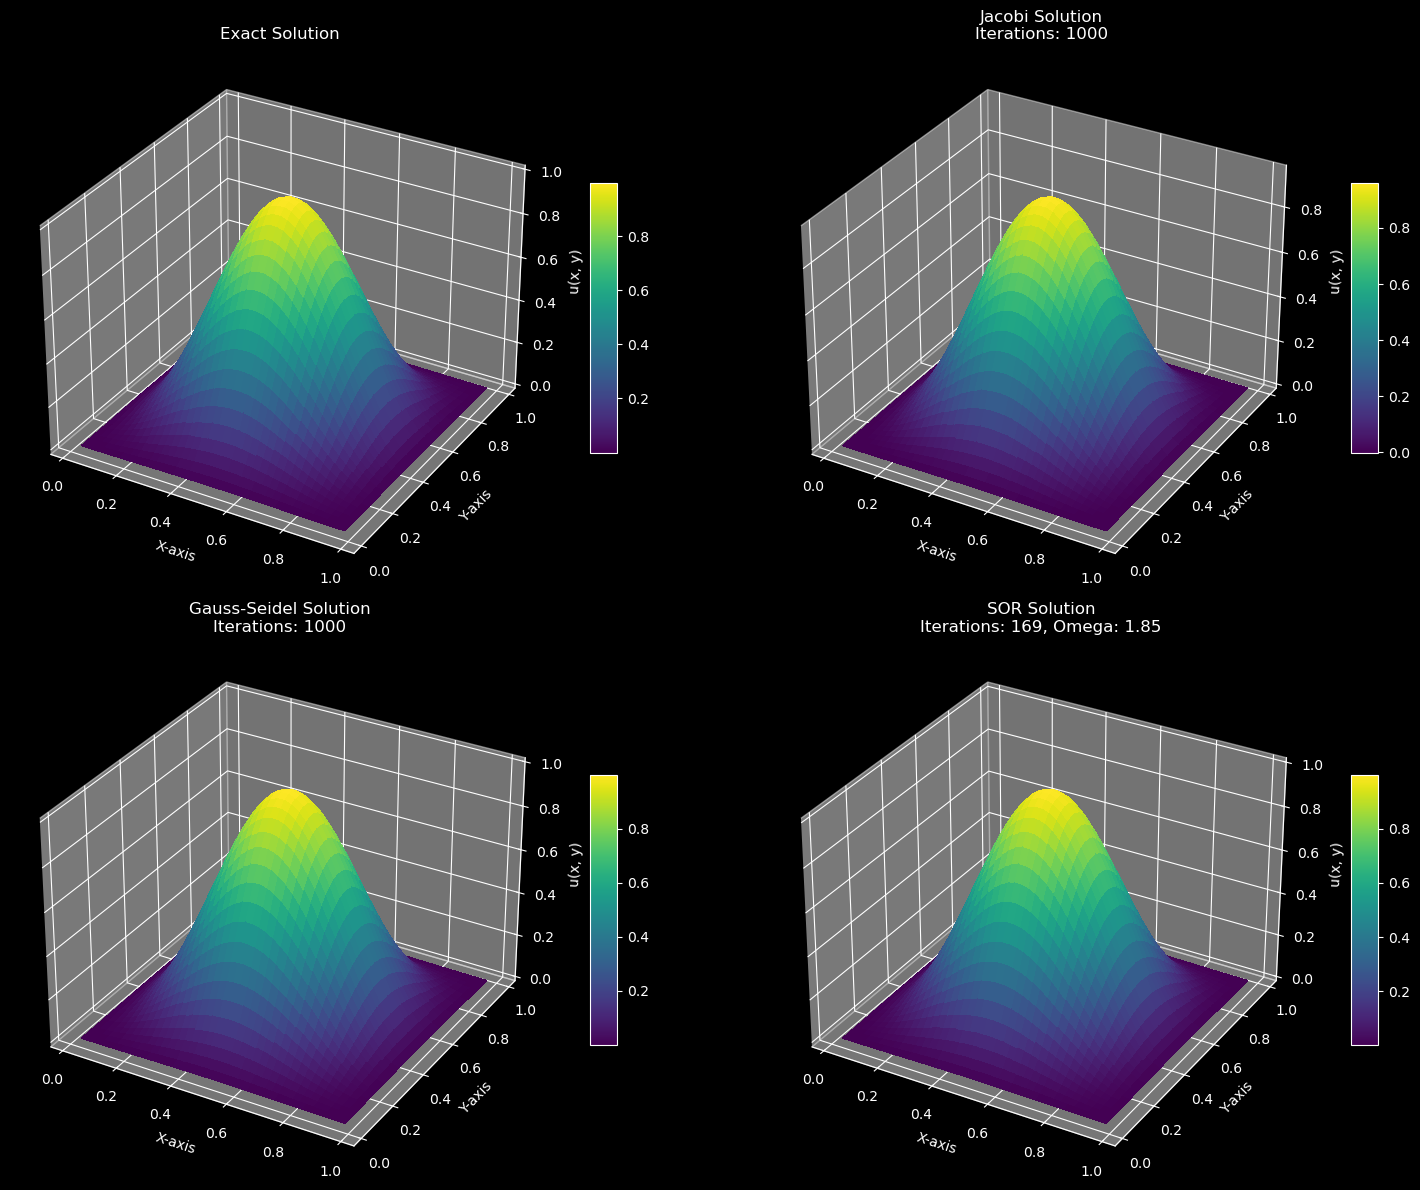

In [111]:
print("\n=== Comparing Iterative Methods with 3D Visualization ===")
compare_iterative_methods_3d()


=== Fourth-Order Finite Difference Solver ===

Solving using Fourth-Order Sparse Matrix Representation...
Fourth-Order Sparse Solver: Time = 0.0091s
relative error = 0.00040296044701554877


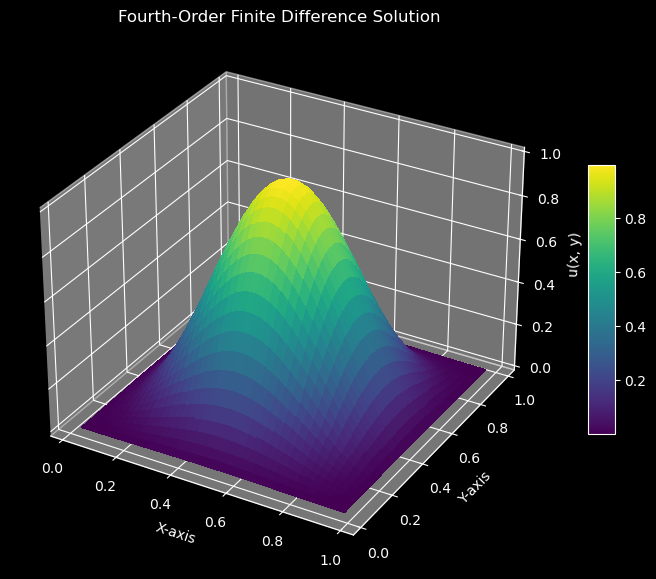

In [109]:
print("\n=== Fourth-Order Finite Difference Solver ===")
# Define grid size for fourth-order solver
Nx, Ny = 40, 40
x, y, X, Y, h_x, h_y = generate_grid(Nx, Ny, 1.0, 1.0)

U_fourth_order, time_fourth_order = solve_poisson_fourth_order(Nx, Ny)

u_exact = exact_solution(X, Y)
rel_error_fourth_order = compute_relative_error(U_fourth_order, u_exact)
print(f'relative error = {rel_error_fourth_order}')

# Optional: Visualize the fourth-order solution
plot_3d_surface(X, Y, U_fourth_order, title='Fourth-Order Finite Difference Solution')



Re-running Second-Order Sparse Solver for Comparison...
Second-Order Sparse Solver: Time = 0.0058s, Relative Error = 1.95939e-03


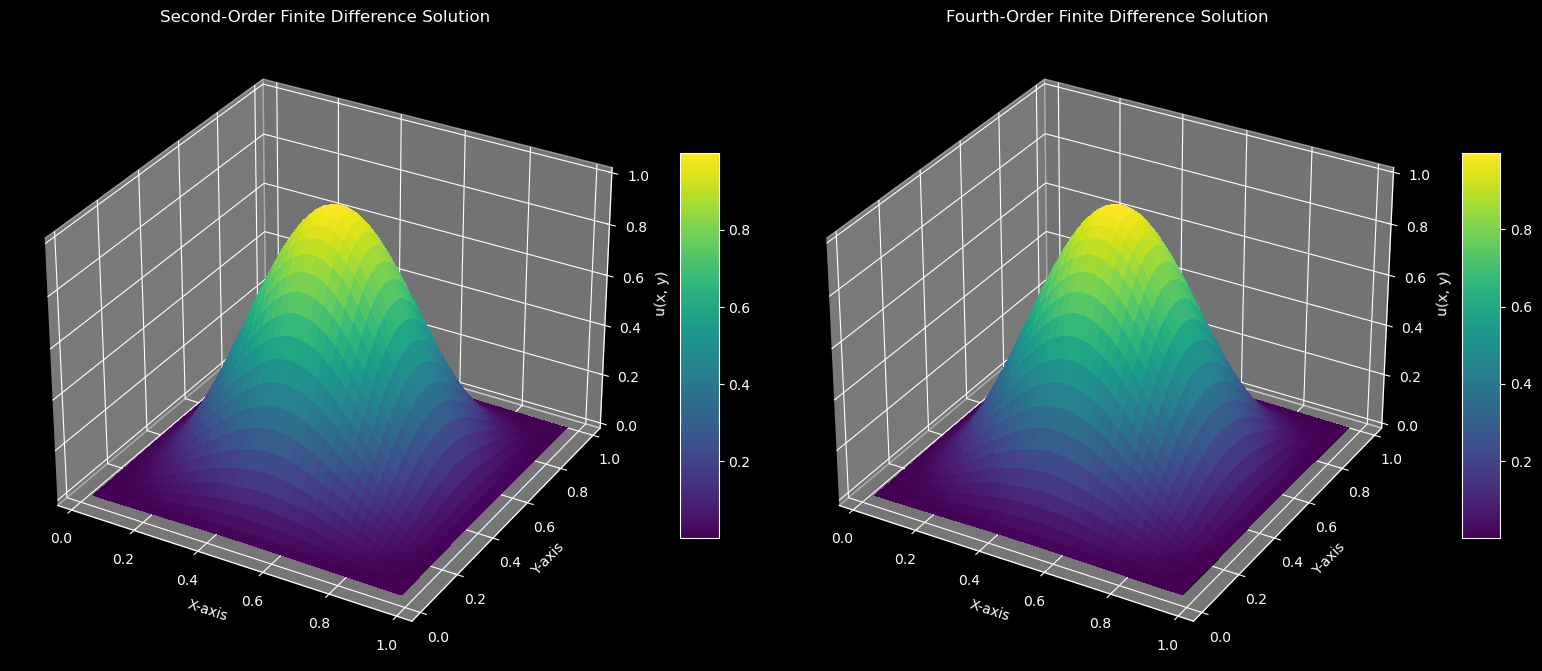


Comparison of Solvers:
Second-Order Solver: Relative Error = 1.95939e-03
Fourth-Order Solver: Relative Error = 4.02960e-04
Error Improvement: 4.862 times more accurate


In [110]:
# Compare with second-order solver
# Reuse the second-order solver's solution
# Assuming 'U_sparse' is available from previous steps
# For clarity, you might need to rerun or store the second-order solution separately

# Here, we assume that perform_direct_methods_comparison does not return values
# Hence, to compare, we need to modify it to return the solutions
# Alternatively, run the fourth-order solver alongside the second-order solver and store their solutions

# To keep it simple, let's assume we have the second-order sparse solution stored as 'U_sparse'
# For demonstration, we'll redefine 'U_sparse' here
print("\nRe-running Second-Order Sparse Solver for Comparison...")

b = assemble_rhs_vector(Nx, Ny, X, Y, exact_rhs, lambda x, y: 0.0, h_x, h_y)
A_sparse = assemble_sparse_matrix(Nx, Ny, h_x, h_y)
u_sparse, time_sparse = solve_poisson_direct(A_sparse, b, method='sparse')
U_sparse = u_sparse.reshape((Nx, Ny))
rel_error_second_order = compute_relative_error(u_sparse, u_exact.flatten())
print(f"Second-Order Sparse Solver: Time = {time_sparse:.4f}s, Relative Error = {rel_error_second_order:.5e}")

# Plotting Comparison
fig = plt.figure(figsize=(16, 8))

# Second-Order Solution
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, U_sparse, cmap=cm.viridis, linewidth=0, antialiased=False)
ax1.set_title('Second-Order Finite Difference Solution')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.set_zlabel('u(x, y)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# Fourth-Order Solution
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, U_fourth_order, cmap=cm.viridis, linewidth=0, antialiased=False)
ax2.set_title('Fourth-Order Finite Difference Solution')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.set_zlabel('u(x, y)')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

# Print Comparison of Errors
print("\nComparison of Solvers:")
print(f"Second-Order Solver: Relative Error = {rel_error_second_order:.5e}")
print(f"Fourth-Order Solver: Relative Error = {rel_error_fourth_order:.5e}")
print(f"Error Improvement: {rel_error_second_order / rel_error_fourth_order:.3f} times more accurate")
